In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as n
import os
import json
import re

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
path = '/content/drive/My Drive/Data/gtdnorm.csv'
df = pd.read_csv(path)

In [ ]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
for i in df.iloc[0]:
  if not (i >= 0 and i <= 1):
    print(i)

10.0


In [ ]:
from torch.utils.data import Dataset

In [ ]:
df = df.iloc[0:93500]

In [ ]:
class GTD(Dataset):
    def __init__(self, df):

        self.x = torch.tensor(df[[i for i in df.columns if i != 'target']].values, dtype=torch.float32)
        self.y = torch.tensor(df.target.values, dtype=torch.long)
        self.n_samples = len(df)

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.n_samples

In [ ]:
gtd_ds = GTD(df)

In [ ]:
len(gtd_ds)

93500

In [ ]:
from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(df))
test_size = len(df) - train_size
train_dataset, test_dataset = random_split(gtd_ds, [train_size, test_size])

In [ ]:
batch_size = 100
num_iters = 3000
input_dim = df.shape[1]-1 # num_features = 43
num_hidden = 100 # num of hidden nodes
output_dim = len(df.target.unique()) #11

learning_rate = 0.001  # More power so we can learn faster! previously it was 0.001

In [ ]:
num_epochs = 25 #num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [ ]:
iter(train_loader)

In [ ]:
for i in train_loader:
  print(i)
  break

[tensor([[0.3704, 0.4975, 0.4621,  ..., 0.9000, 0.0000, 0.9000],
        [0.5618, 0.5614, 0.5079,  ..., 1.0000, 0.0000, 1.0000],
        [0.6254, 0.5978, 0.6062,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.5467, 0.6272, 0.6265,  ..., 0.0000, 0.0000, 0.0000],
        [0.2985, 0.5792, 0.4524,  ..., 0.9000, 0.0000, 0.9000],
        [0.6094, 0.6337, 0.7767,  ..., 1.0000, 0.0000, 1.0000]]), tensor([ 3, 10,  0,  0, 10,  0,  0, 10,  0,  2, 10, 10,  0, 10,  0,  0,  0,  0,
        10,  0,  1, 10,  0,  8,  8,  3,  0,  2,  0, 10,  0,  0,  0,  0, 10, 10,
        10,  0,  0, 10, 10,  1,  6,  2,  0,  1,  3,  7,  4,  2, 10,  0,  0,  0,
         0,  2,  0, 10,  0,  1, 10,  0,  2,  1,  6, 10, 10, 10,  2,  0, 10,  0,
         0,  0, 10,  0,  0, 10,  0, 10,  0,  0,  0, 10,  0,  0,  0,  9,  0, 10,
         0,  0, 10, 10,  1,  0, 10,  0, 10,  2])]


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, cnn_kernel_size, cnn_stride):
        super(LSTMModel, self).__init__()


        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # CNN layer
        self.cnn = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=cnn_kernel_size, stride=cnn_stride)

        self.gru = nn.GRU(1577, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        cnn_output = self.cnn(x)

        # Apply LSTM
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        lstm_output, _ = self.gru(cnn_output, (h0.detach()))

        # Index hidden state of last time step
        lstm_output = self.fc(self.relu(lstm_output[:, -1, :]))

        return lstm_output


# hyperparameters
input_size = input_dim  # Number of input features
hidden_size = 128  # Number of LSTM hidden units
num_layers = 2  # Number of LSTM layers
output_size = 11  # Number of output classes
cnn_kernel_size = 3  # Kernel size for the CNN layer
cnn_stride = 1  # Stride for the CNN layer

# Instantiate the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size, cnn_kernel_size, cnn_stride).to(device)
print(model)

LSTMModel(
  (cnn): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
  (gru): GRU(1577, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=11, bias=True)
  (relu): ReLU()
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
num_epochs = 100

In [ ]:
iter = 0
for epoch in range(num_epochs):

  for i, (inputs, labels) in enumerate(train_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      outputs = model(inputs.reshape(100, 1, input_dim))

      loss = criterion(outputs, labels)

      loss.backward()

      optimizer.step()

      iter += 1
      if iter % 500 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0

            for input, labels in test_loader:
                input = input.to(device)

                # Forward pass only to get logits/output
                outputs = model(input.reshape(100, 1, input_dim))

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = correct / total * 100
            print('Accuracy:', accuracy)
  print('Epoch [{}/{}] Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Accuracy: tensor(96.7433)
Epoch [1/100] Loss: 0.0380
Accuracy: tensor(97.9198)
Epoch [2/100] Loss: 0.0604
Accuracy: tensor(98.2406)
Accuracy: tensor(98.2460)
Epoch [3/100] Loss: 0.0101
Accuracy: tensor(98.5401)
Epoch [4/100] Loss: 0.0164
Accuracy: tensor(98.5401)
Accuracy: tensor(98.5134)
Epoch [5/100] Loss: 0.0599
Accuracy: tensor(98.4866)
Epoch [6/100] Loss: 0.0576
Accuracy: tensor(98.5455)
Accuracy: tensor(98.3690)
Epoch [7/100] Loss: 0.0562
Accuracy: tensor(98.5294)
Epoch [8/100] Loss: 0.0077
Accuracy: tensor(98.7166)
Accuracy: tensor(98.5829)
Epoch [9/100] Loss: 0.0098
Accuracy: tensor(98.6417)
Epoch [10/100] Loss: 0.0009
Accuracy: tensor(98.6578)
Accuracy: tensor(98.3690)
Epoch [11/100] Loss: 0.0413


In [ ]:
import numpy as np

In [ ]:
Toyp = np.array([])
yt = np.array([])

for input, labels in test_loader:

                input = input.to(device)

                # Forward pass only to get logits/output
                outputs = model(input.reshape(100, 1, input_dim))

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
                predicted=predicted.to('cpu')


                yp = np.concatenate((yp, predicted.numpy()))
                yt = np.concatenate((yt, labels.numpy()))

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

print(yt.shape, yp.shape)
print(yt[:10])
print(yp[:10])


(18700,) (18700,)
[ 0.  0.  2. 10.  0.  0.  0. 10.  1.  0.]
[ 0.  0.  2. 10.  0.  0.  0. 10.  1.  0.]


In [ ]:
res = yt==yp
print(res.sum())

18483


In [ ]:
from sklearn import metrics

cm = metrics.confusion_matrix(yt, yp)

In [ ]:
cm

array([[9345,    1,    0,    0,    0,    1,    0,    2,    0,    0,   69],
       [   0, 1306,    0,    0,    0,    0,    0,    0,    0,    0,    7],
       [   0,    0,  971,    0,    0,    0,    0,    0,    0,    0,    8],
       [   0,    0,    1,  496,    0,    0,    0,    0,    0,    0,    7],
       [   0,    0,    0,    0,  365,    0,    0,    0,    0,    0,    2],
       [   0,    0,    0,    0,    0,  392,    0,    0,    0,    0,    4],
       [   0,    0,    0,    0,    0,    0,  353,    0,    0,    0,    3],
       [   2,    0,    0,    0,    0,    0,    0,  283,    0,    0,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,  199,    0,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,  206,    1],
       [  67,   15,    2,    4,    0,    2,    4,    2,    8,    3, 4567]])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

<function matplotlib.pyplot.show(close=None, block=None)>

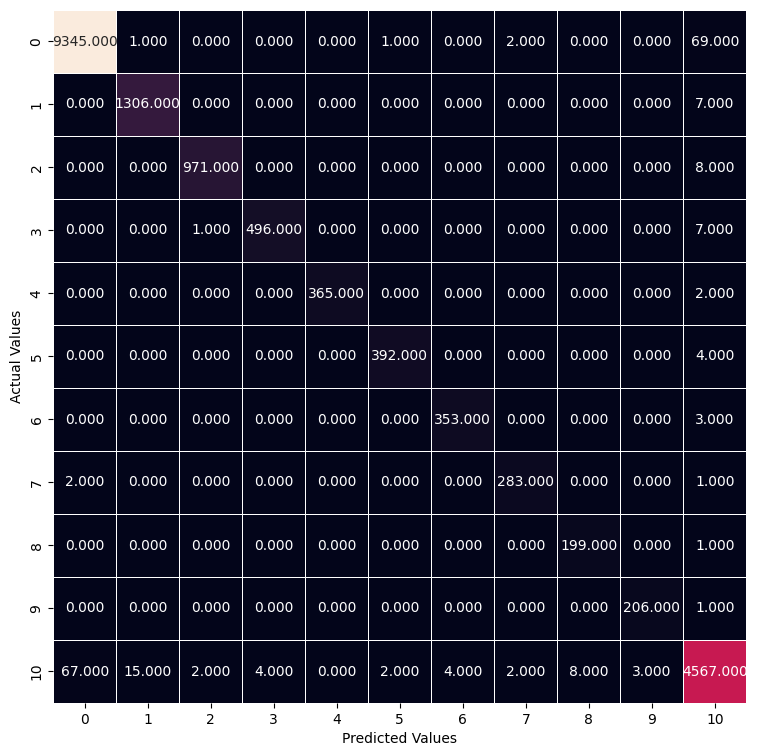

In [ ]:
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot = True, fmt = '0.3f', linewidth = 0.5, square = True, cbar = False)
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show

In [ ]:
print(metrics.classification_report(yt, yp))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      9418
         1.0       0.99      0.99      0.99      1313
         2.0       1.00      0.99      0.99       979
         3.0       0.99      0.98      0.99       504
         4.0       1.00      0.99      1.00       367
         5.0       0.99      0.99      0.99       396
         6.0       0.99      0.99      0.99       356
         7.0       0.99      0.99      0.99       286
         8.0       0.96      0.99      0.98       200
         9.0       0.99      1.00      0.99       207
        10.0       0.98      0.98      0.98      4674

    accuracy                           0.99     18700
   macro avg       0.99      0.99      0.99     18700
weighted avg       0.99      0.99      0.99     18700

